In [1]:
import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

Goal: (like the first lecture/notebook) generate _more_ rows of text that are like the ones fed in first. Here, do this by picking a character that is likely, based on the three previous characters.

"We're maximizing the probability of the word, with respect to the parameters of the neural net. The parameters are the weights and biases of the output layer that does a softmax, the hidden layer, and the (character) embedding look up table layer called C."  

# Prep

In [2]:
# start w/ the words (names)
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocab of characters and mapping from/to integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


# Build the dataset

In [48]:
# build the dataset
block_size = 3 # context length of how many chars to predict the next one
X, Y = [], []

for w in words:
#for w in words[:5]:
    #print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(itos[i] for i in context), '-->', itos[ix], context)
        context = context[1:] + [ix] # crop first char and append current label
        
X = torch.tensor(X)
Y = torch.tensor(Y)

In [49]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [50]:
len(X)

228146

The X dataset is a row per each combination of three characters - including three '.' chars that indicate the start (or end) of the word - in each word in the input, with the actual data in the row an array of integers. The Y dataset is the integer of the _next_ character after the three. So, with the single input row 'emma', we generate five dataset rows, starting with '...'->'e' and ending with 'mma'->'.'. When we work w/ just the first five words, we get 32 rows/combinations of three characters.

Here's where I updated things to create a training, dev/validation, and test split.

In [132]:
def build_dataset(words):
    block_size = 3 # context length of how many chars to predict the next one
    X, Y = [], []

    for w in words:
    #for w in words[:5]:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '-->', itos[ix], context)
            context = context[1:] + [ix] # crop first char and append current label

    X = torch.tensor(X)
    Y = torch.tensor(Y)    
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words)) # 80% for training
n2 = int(0.9*len(words)) # 90% - 10% for dev/validation, 10% for test

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [133]:
# training words
n1

25626

In [134]:
# dev/validation words
n2 - n1

3203

In [137]:
# test words
len(words) - n2

3204

# Build the embedding layer C

In [8]:
embedding_dims = 2

C = torch.randn(27, embedding_dims)

One way to think about the embedding layer is to think of indexing into an array that maps character indexes into two-dimensional floats.

In [9]:
C[5]

tensor([-0.6858, -0.7519])

Another way to think of the embedding layer is that it's just another layer in the neural net, but one with no bias weights and without a non-linearity (like tanh). Conceptually here we one-hot encode the character we want to provide as input and then matmul that one-hot encoded input with the C layer. The one-hot encoded input has all zeros except for a one in the spot that matches the index we care about - 5 in this example - and so we 'pull out' only the values from C in that row. Ultimately we get the same result.

In [10]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([-0.6858, -0.7519])

Indexing is faster, so we'll do that.

We want to embed not just a single character, but instead the three chars we have as input. PyTorch indexing is powerful and accepts a lot of different things, including lists, and even multi-dimensional arrays/tensors. X is our input data - it's a tensor with many rows -when we test w/ just five words of input, 32 rows - and each row having three numbers, one for each character. We want a mapping between ALL of these rows and characters to the floating point numbers that represent/embed each character. Ultimately, with 32 rows and three characters each, we want an output that's 32 rows by 3 characters by 2 floats. PyTorch indexing is powerful, so to get this, all we have to do is index into C with the full X array (which again has a shape of 32, 3). PyTorch will pick out the appropriate 2D embedding values and return a tensor of shape 32, 3, 2. 

In [11]:
emb = C[X] # this embeds ALL of the dataset's characters in C
emb.shape

torch.Size([32, 3, 2])

In [12]:
emb[:3]

tensor([[[-0.6255, -1.2843],
         [-0.6255, -1.2843],
         [-0.6255, -1.2843]],

        [[-0.6255, -1.2843],
         [-0.6255, -1.2843],
         [-0.6858, -0.7519]],

        [[-0.6255, -1.2843],
         [-0.6858, -0.7519],
         [ 0.3411,  1.0509]]])

In [13]:
X[2, 1]

tensor(5)

In [14]:
emb[2, 1]

tensor([-0.6858, -0.7519])

# Building the hidden layer

In [15]:
# how many floating point inputs to the hidden layer?
# for three char inputs with two floats per char, it's 6
input_chars = block_size * embedding_dims
input_chars

6

In [16]:
hidden_neurons = 100

W1 = torch.randn((input_chars, hidden_neurons)) # 6, 100
b1 = torch.randn(hidden_neurons) # 100

We want to do emb @ W1 + b. We can't, right now, because embd is 32, 3, 2 while W1 is 6, 100. We want to combine the 3, 2 part into a single dimension of size 6, so we'll have 32x6, which we can then matmul with 6x100.

In [17]:
# one inefficient way is via cat
emb[:, 0, :].shape # single 32 by 2 embeddings for the first char

torch.Size([32, 2])

In [18]:
# all three chars then are as follows, which gives us 32,6 as we want
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape # concat on dim 1, not zero

torch.Size([32, 6])

In [19]:
# the above doesn't generalize because it hardcodes block size of three
# i could use 'unbind' to 'remove a tensor dimension'
# unbind gives a list of tensors like the hard-codet just above
torch.cat(torch.unbind(emb, 1), 1).shape

torch.Size([32, 6])

But, both of the above are using new memory. Instead, we can use 'view' to just change the metadata on the underlying data - each tensor has underlying storage that's just a 1D set of data - and get a diff view without having to do anything with new data.

In [20]:
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [21]:
a.view(9, 2)

tensor([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11],
        [12, 13],
        [14, 15],
        [16, 17]])

In [22]:
a.view(3, 3, 2)

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

In [23]:
emb.shape

torch.Size([32, 3, 2])

In [24]:
emb.view(32, 6)

tensor([[-0.6255, -1.2843, -0.6255, -1.2843, -0.6255, -1.2843],
        [-0.6255, -1.2843, -0.6255, -1.2843, -0.6858, -0.7519],
        [-0.6255, -1.2843, -0.6858, -0.7519,  0.3411,  1.0509],
        [-0.6858, -0.7519,  0.3411,  1.0509,  0.3411,  1.0509],
        [ 0.3411,  1.0509,  0.3411,  1.0509, -0.7718,  0.8061],
        [-0.6255, -1.2843, -0.6255, -1.2843, -0.6255, -1.2843],
        [-0.6255, -1.2843, -0.6255, -1.2843,  1.3296, -0.3574],
        [-0.6255, -1.2843,  1.3296, -0.3574,  0.3403, -0.5097],
        [ 1.3296, -0.3574,  0.3403, -0.5097, -1.2017, -0.3589],
        [ 0.3403, -0.5097, -1.2017, -0.3589, -0.8617, -0.7880],
        [-1.2017, -0.3589, -0.8617, -0.7880, -1.2017, -0.3589],
        [-0.8617, -0.7880, -1.2017, -0.3589, -0.7718,  0.8061],
        [-0.6255, -1.2843, -0.6255, -1.2843, -0.6255, -1.2843],
        [-0.6255, -1.2843, -0.6255, -1.2843, -0.7718,  0.8061],
        [-0.6255, -1.2843, -0.7718,  0.8061, -0.8617, -0.7880],
        [-0.7718,  0.8061, -0.8617, -0.7

In [25]:
# view and unbind give the same result
emb.view(32, 6) == torch.cat(torch.unbind(emb, 1), 1)

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

The above does rely on the fact that 'view', when asked for a 32x6 from our 32x3x2, combines each of the 3x2 into a single 6. (Or rather, that the underlying data for the 3x2 is a 1D sequence of six values.)

In [26]:
# ultimately, we can do our matmul to get the hidden layer vals
h = emb.view(32, 6) @ W1 + b1
h

tensor([[-4.6885,  1.7984, -0.5017,  ...,  2.0045,  1.2657,  7.6324],
        [-4.2666,  2.1013, -0.4891,  ...,  2.0728,  1.0189,  6.6183],
        [-2.0902,  2.6800, -2.1972,  ...,  3.2927,  2.4481,  2.0328],
        ...,
        [ 2.1487,  0.6642,  1.8126,  ...,  1.7950, -0.6022,  4.3396],
        [-1.9477,  1.6876,  1.3532,  ...,  0.5476, -3.8667, -4.3770],
        [-0.6151,  2.1599,  0.9927,  ...,  0.7803, -1.6662,  4.7585]])

In [27]:
h.shape

torch.Size([32, 100])

In [28]:
h = emb.view(-1, 6) @ W1 + b1 # -1 is same as len(emb), -1 sets the dim to fit the underlying data
h.shape

torch.Size([32, 100])

In [29]:
len(emb)

32

In [30]:
h = torch.tanh(emb.view(-1, input_chars) @ W1 + b1)
h

tensor([[-0.9998,  0.9466, -0.4634,  ...,  0.9643,  0.8526,  1.0000],
        [-0.9996,  0.9705, -0.4535,  ...,  0.9688,  0.7694,  1.0000],
        [-0.9699,  0.9906, -0.9756,  ...,  0.9972,  0.9852,  0.9663],
        ...,
        [ 0.9732,  0.5812,  0.9481,  ...,  0.9463, -0.5386,  0.9997],
        [-0.9601,  0.9338,  0.8748,  ...,  0.4987, -0.9991, -0.9997],
        [-0.5477,  0.9737,  0.7585,  ...,  0.6529, -0.9310,  0.9999]])

Also, he talked about confirming that b1 is broadcast to each row of the result of the matmul. So, I think it's that we have 32 input rows of six values each, and our W1 tensor is 6x100. 

First, I want to remember that we have 100 hidden neurons, each of which is connected to six input neurons. For each of the 100 hidden neurons we have six weights, one for each of the inputs. This is what makes W1 6,100. We also have a single 100 length bias vector - each value applies to one hidden neuron and is the same/doesn't change or depend upon the number of connected input neurons. Ultimately, the calc for the hidden layer is, per hidden layer neuron, a set of six (normal) multiplications each of the floating point input value multiplied by the specific weight for the combination of that neuron AND that input value, the sum of which is then added to the single bias value for that neuron.    

The matmul is 32,6 @ 6,100 -> 32,100. We know the matmul takes the six values in the first row and multiplies them by the six values in the first column, and then adds the result and stores it as the value of the first row and column of the ultimate 32,100 tensor. It multiplies the same six input values from the first row by the six values in each of the remaining 99 columns to fill out the 100 columns in the first of 32 rows. Then, finally, it does the same for the remaining 31 rows in the input tensor, generating 100 values each time, to get the fill out the full 32 rows of the 32,100 result. Here, we're doing 32*100 calcs -> 3200 total calcs. Our bias vector is just 100 values. We want it to be broadcast to each of the calcs we do for each of the 32 input rows. PyTorch will do this, because we start with 32,100 and are adding a 100. PyTorch lines up the 100 w/ the right-most dimension, I think, and then fills in the missing dim with '1', making a 1,100 tensor, which adds to each row the 32,100 matmul result.

In [31]:
W1.shape

torch.Size([6, 100])

# Building the final output softmax/probability layer

In [32]:
# final layer is 100,27 - 100 input neurons from the hidden layer
# mapping to 27 output neurons, one for each character
W2 = torch.randn((hidden_neurons, 27)) # 100, 27
b2 = torch.randn(27)

In [33]:
# and since we have a 32,100 input, matmul with 100,27 -> 32,27
logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

In [34]:
# logits are log counts, so first exponentiate to get 'fake counts'
counts = logits.exp()

In [35]:
# then normalize to get probabilities
prob = counts / counts.sum(1, keepdims=True)
prob.shape

torch.Size([32, 27])

In [36]:
prob[17].sum()

tensor(1.)

In [37]:
# actual error, based on ground truth Y (next char in seq)
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

Ultimately, we want to index into the probabilities (one for each of the 27 chars) our model generated and pull out the specific probability for the ground truth/actual character we want the model to choose. We want this probability to be as high as possible, since high probabilities mean the model is more likely to pick the correct character. (Note that for many - all? - chars it's impossible to get a probability of 1 because in the actual data it's likely not always the case that, for even a single character, that the next character is always the same.)

In [38]:
# first param - range of 32 - indexes into prob once for each of the rows in prob
# second param - Y - is a matching length (we have one ground truth for each input)
# and the value in Y is the index into the 27 probabilities
# ultimately this gives us the probability for the correct next char for each input row
prob[torch.arange(32), Y]

tensor([2.7152e-10, 6.8770e-10, 1.3817e-02, 3.5121e-08, 9.6131e-11, 6.3133e-10,
        2.5597e-07, 1.1481e-06, 3.1222e-03, 1.3037e-13, 5.9067e-08, 1.2573e-06,
        1.5142e-10, 1.1750e-10, 2.7128e-01, 9.8952e-01, 3.0114e-17, 2.3178e-12,
        6.5133e-12, 4.6180e-08, 4.4640e-03, 3.3532e-10, 6.0546e-07, 1.3365e-16,
        2.1070e-04, 3.8987e-13, 5.2856e-14, 3.2494e-04, 8.0134e-10, 2.8131e-09,
        1.7699e-08, 5.5911e-05])

Many of the probabilities are horrible - likely close to zero. But we haven't trained the model yet.

Finally, we want to get a single score from all of the input rows and ground truth values we've tried. Our single score is negative of the average of the log probability of each of the values. This creates the negative log likelihood loss.  

In [39]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(18.1133)

# Cleaned up and pulled together first cut at a model that minimizes the loss

In [65]:
karpathy_seed = 2147483647

In [66]:
embedding_dims = 2
hidden_neurons = 100

In [67]:
print(block_size) # don't set here because it affects the X, Y data
X.shape, Y.shape

3


(torch.Size([228146, 3]), torch.Size([228146]))

In [157]:
g = torch.Generator().manual_seed(karpathy_seed)
C = torch.randn((27, embedding_dims), generator=g) # 27,2
W1 = torch.randn((block_size*embedding_dims, hidden_neurons), generator=g) # 6, 100
b1 = torch.randn(hidden_neurons, generator=g)
W2 = torch.randn((hidden_neurons, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [158]:
# how many total parameters are we finding?
sum(p.nelement() for p in parameters)

3481

The cross_entropy fuinction used below replaces the manual calc of probabilities and the calc of the loss function - it just needs logits (log counts) and the ground truth. Besides being canned and so easier to read/search for/understand/without roll-your-own bugs, it's more efficient - doesn't create new tensors, uses 'fused kernels', and simpler/direct 'clustered' backward pass math. It also is also better behaved numerically because it avoids very large logits by shifting down, avoiding floating point inf values.

I also added in minibatches. We can - and we did when we started - do each iteration - each forward/backward pass - using _all_ of the 200K+ rows. This gives us a gradient that's accurate in that it reflects all the data, but it takes a long time to do each iteration since our tensors have a lot of dimensions that have 200K+ rows. An alternative is to use 'minibatches' - for each iteration, randomly sample a much smaller subset of rows - the minibatch - and do the forward/backward gradient calculation using only this data. This gives gradients that can jump around and that are likely to be further from the gradient calculated from all data, but they still push us in mostly the same/correct direction, AND calculating with 32 input rows vs 200K+ is MUCH faster. (Also, I'd guess that since we're randomly sampling the variation in the gradients will average out to something close to the gradient from all the data.)

Also, I think if I recall correctly - I thought about this in the pool at the Elua - that there's a gradient value per mathematical node in the graph of all the calcs. This matches the idea that the number of inputs doesn't change the number of gradient values, since the number of gradient values is defined by the number of nodes in the neural net and how the nodes are connected. I think. I could rewatch the micrograd talk now that I want to make sure this is correct/understand it.

In [159]:
for p in parameters:
    p.requires_grad = True

In [160]:
# we want to try diff learning rates - we want more granularity at
# small rates and less at the top, so instead of just using linspace
# directly, we'll use linspace to get a linea set of numbers and then
# use those numbers as exponents, to get the difference in granularity
# we want (this is to get the best rate to train normally - diff from
# 'learning rate decay' where we finish things out with a smaller 
# learning rate than we use normally)
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [172]:
lri = []
lossi = []

for i in range(1000):
    
    # if using minibatches/not training each iteration on the full 200K+ dataset
    minibatch_size = 64
    ix = torch.randint(0, X.shape[0], (minibatch_size,))

    # forward pass
    emb = C[X[ix]] # 32, 3, 2 # w/ minibatch
    # emb = C[X] # 32, 3, 2 - w/o minibatch
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # 32, 100
    logits = h @ W2 + b2 # 32, 27
    loss = F.cross_entropy(logits, Y[ix]) # with minibatch
    #loss = F.cross_entropy(logits, Y) # w/o minibatch 
    #print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    #lr = lrs[i] # pull from our changing learning rate array, starts low and gets bigger
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    lri.append(lre[i])
    lossi.append(loss.item())
        
print(loss.item()) # loss for just the last minibatch

2.1344239711761475


The original loss was very low (I think I remember < 1), but it's because our input data when we start is only 32 rows and we have ~3500 params, so we crazy overfit. (We can't overfit to a loss of zero because in some cases - like with the first char of the word, we have many diff input values - of [0, 0, 0] - that map to different output values.) When we pull in the full set of data and get 200K+ input rows, the loss doesn't go as low.

In [131]:
# what's the loss on the whole dataset? formulas are the same, just
# the data fed to the first layer and the number of Y vals matches
emb = C[X] # no longer a 32 row minibatch
print(emb.size())
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # 32, 100
logits = h @ W2 + b2 # 32, 27
loss_full_dataset = F.cross_entropy(logits, Y) 
loss_full_dataset.item()

torch.Size([228146, 3, 2])


2.3062076568603516

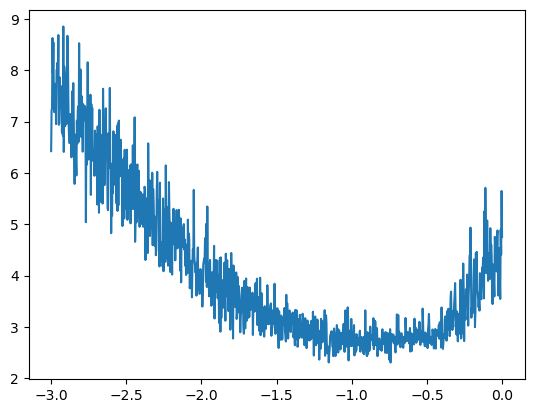

In [163]:
# doesn't work unless stats stuff above is uncommented
plt.plot(lri, lossi)

# Update for training, dev/validation, and test splits

Training - say 80% - is to optimize the actual parameters of the model - the weights, etc. - as we've done above; dev/validation - 10% - is for tuning hyperparameters of the model - for ex, size of the hidden layer or size of embedding or amount of regularization; and test - 10% for the last number that we'd report.

I updated the code up top where I created the X and Y datasets to do the split.

In [ ]:
embedding_dims = 2
hidden_neurons = 100 

In [173]:
g = torch.Generator().manual_seed(karpathy_seed)
C = torch.randn((27, embedding_dims), generator=g) # 27,2
W1 = torch.randn((block_size*embedding_dims, hidden_neurons), generator=g) # 6, 100
b1 = torch.randn(hidden_neurons, generator=g)
W2 = torch.randn((hidden_neurons, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [174]:
# how many total parameters are we finding?
sum(p.nelement() for p in parameters)

3481

In [175]:
for p in parameters:
    p.requires_grad = True

In [180]:
for i in range(10000):
    
    # if using minibatches/not training each iteration on the full 200K+ dataset
    minibatch_size = 64
    ix = torch.randint(0, Xtr.shape[0], (minibatch_size,))

    # forward pass
    emb = C[Xtr[ix]] # 32, 3, 2 # w/ minibatch
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # 32, 100
    logits = h @ W2 + b2 # 32, 27
    loss = F.cross_entropy(logits, Ytr[ix]) # with minibatch
    #print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad
        
print(loss.item()) # loss for just the last minibatch

2.5789387226104736


In [182]:
emb = C[Xtr] 
print(emb.size())
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # 32, 100
logits = h @ W2 + b2 # 32, 27
loss_full_dataset = F.cross_entropy(logits, Ytr) 
loss_full_dataset.item()

torch.Size([182625, 3, 2])


2.3465025424957275

In [181]:
emb = C[Xdev] 
print(emb.size())
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # 32, 100
logits = h @ W2 + b2 # 32, 27
loss_full_dataset = F.cross_entropy(logits, Ydev) 
loss_full_dataset.item()

torch.Size([22655, 3, 2])


2.3444454669952393

Since the loss (on all of) the training and (all of the) test data is about the same, this means we're _not_ overfitting on the training data. When we don't overfit on the training data, that's typically because the model isn't powerful enough (to learn the training data) - it doesn't have enough parameters.

The last 15m of the video has him doing some additional optimization, including increasing the size of the hidden layer, increasing a bit the size of the minibatch (to avoid thrashing). He didn't see much improvement here, so he also talked about increasing the size of the embedding layer - figuring that it might be the bottleneck in the network because increasing the hidden layer from 100 to 300 didn't change much. As part of this he also wrote code that drew a visualization of the embedding - since we start w/ this at 2 floating point numbers, we can visualize them on a plane. The video shows how the network's learned to cluster vowels (since they can be used in similar spots in a word). It also learns to put a few characters away from all others, when they're odd - it does this w/ 'q' and the '.' special character. When he increased the embedding size to 10 and reduced the hidden layer down to I think 200 or so, he saw that the training loss started to tend lower than than test loss, supporting the idea that the embedding layer was holding back the scores. He finished up by adding a learning rate decay. He ended up w/ a best test loss of 2.17, and finished up in the last few mins w/ laying out all the different parts that could be further optimized to potentially improve on this number (including using more than three characters as input). And in the very last minute or two how to sample from the model to get new names.

In [185]:
# sample from the model
g = torch.Generator().manual_seed(karpathy_seed + 15)

for _ in range(30):
    out = []
    context = [0] * block_size # start with ...
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
        
    print(''.join(itos[i] for i in out))

ameyah.
zabhen.
hekanniyandya.
anberier.
hil.
saz.
chen.
diolan.
mar.
havieieya.
wasminledethominra.
pax.
tosolimiuh.
riceeyo.
ashoni.
ansa.
bunander.
jaxalikr.
bina.
edbyo.
jahgyszectaniiye.
caidara.
ail.
maswaya.
kamiyahvayahah.
sinley.
anialah.
ella.
dowiej.
cadie.
